Social Media Engagement Predictor

---



Starchuk Diana 31041

Oleksandra Lagutina 31142

Artem Kuhai 31084

Cel: Przewidzenie wysokiego zaangażowania posta (High Engagement)

Opis: Model uczenia maszynowego analizujący cechy posta w celu określenia, czy osiągnie on wysoki poziom zaangażowania.

IMPORT BIBLIOTEK


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import unittest
import pickle
import os
import sys

# Biblioteki do Machine Learning (Scikit-learn)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ustawienia wykresów
sns.set(style="whitegrid")
%matplotlib inline

KLASA 1: OBSŁUGA DANYCH (DATA HANDLER)

In [12]:
class DataHandler:

   # Klasa odpowiedzialna za wczytywanie i wstępną analizę danych (EDA).
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = None

    def load_data(self):
        """Wczytuje dane z pliku CSV."""
        if not os.path.exists(self.filepath):

            return None

        try:
            self.df = pd.read_csv(self.filepath)
            print(f" Dane załadowane pomyślnie. Rozmiar danych: {self.df.shape}")
            return self.df
        except Exception as e:
            print(f" Wystąpił błąd podczas wczytywania: {e}")
            return None

    def perform_eda(self):
        """Wykonuje wstępną analizę danych (Exploratory Data Analysis)."""
        if self.df is None: return

        print("\n--- 1. Podstawowe statystyki (Statystyka opisowa) ---")
        display(self.df.describe())

        print("\n--- 2. Sprawdzenie brakujących wartości (Missing Values) ---")
        print(self.df.isnull().sum())

        # Wykres rozkładu zmiennej celu
        plt.figure(figsize=(6, 4))
        sns.histplot(self.df['engagement_rate'], bins=30, kde=True)
        plt.title("Rozkład wskaźnika zaangażowania (Engagement Rate)")
        plt.xlabel("Wskaźnik zaangażowania")
        plt.ylabel("Liczba postów")
        plt.show()

        # Macierz korelacji (tylko dla kolumn liczbowych)
        plt.figure(figsize=(10, 6))
        numeric_df = self.df.select_dtypes(include=['number'])
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Macierz korelacji (Correlation Matrix)")
        plt.show()

 KLASA 2: PRZETWARZANIE DANYCH (PREPROCESSOR)

In [13]:
class DataPreprocessor:
    """
    Klasa odpowiedzialna za przygotowanie danych:
    - Normalizacja (StandardScaler)
    - Wektoryzacja (OneHotEncoder)
    - Podział na zbiór treningowy i testowy
    """
    def __init__(self, df):
        self.df = df.copy()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def prepare_inputs(self):
        """Przygotowuje cechy (Features) i zmienną docelową (Target)."""

        # klasyfikacja binarna: 1 = Sukces (powyżej mediany), 0 = Porażka
        threshold = self.df['engagement_rate'].median()
        self.df['is_successful'] = (self.df['engagement_rate'] > threshold).astype(int)

        print(f" Próg sukcesu (mediana engagement): {threshold:.5f}")

        # Usuwanie wycieku danych (Data Leakage)
        features = ['platform', 'post_type', 'post_length']
        X = self.df[features]
        y = self.df['is_successful']

        # Podział na zbiór treningowy i testowy (Train/Test Split)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f" Dane podzielone. Treningowe: {self.X_train.shape[0]}, Testowe: {self.X_test.shape[0]}")
        return self.X_train, self.X_test, self.y_train, self.y_test

    def get_pipeline(self, classifier):
        """Tworzy potok (Pipeline) przetwarzania danych."""
        numeric_features = ['post_length']
        numeric_transformer = StandardScaler()

        categorical_features = ['platform', 'post_type']
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        return Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

KLASA 3: TRENOWANIE MODELU (TRAINER)

In [14]:
class ModelTrainer:
    """
    Klasa odpowiedzialna za trenowanie, dostrajanie (fine-tuning) i ocenę modeli.
    """
    def __init__(self, preprocessor_obj):
        self.prep = preprocessor_obj
        self.best_model = None

    def train_baseline(self):
        """Trenuje model bazowy: Regresja Logistyczna."""
        print("\n=== Trenowanie modelu bazowego (Logistic Regression) ===")
        pipeline = self.prep.get_pipeline(LogisticRegression())

        pipeline.fit(self.prep.X_train, self.prep.y_train)
        y_pred = pipeline.predict(self.prep.X_test)

        acc = accuracy_score(self.prep.y_test, y_pred)
        print(f"Dokładność (Accuracy): {acc:.4f}")
        print("\n--- Raport klasyfikacji ---")
        print(classification_report(self.prep.y_test, y_pred))

    def train_tuned_rf(self):
        """Trenuje zaawansowany model: Random Forest z Grid Search (Fine Tuning)."""
        print("\n=== Trenowanie modelu Random Forest (z optymalizacją) ===")

        pipeline = self.prep.get_pipeline(RandomForestClassifier(random_state=42))

        # Siatka parametrów do sprawdzenia
        param_grid = {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5]
        }

        grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
        grid_search.fit(self.prep.X_train, self.prep.y_train)

        self.best_model = grid_search.best_estimator_
        print(f" Najlepsze parametry: {grid_search.best_params_}")

        # Ocena najlepszego modelu
        self.evaluate_final_model()

    def evaluate_final_model(self):
        """Ocenia i wizualizuje wyniki najlepszego modelu."""
        if self.best_model is None: return

        y_pred = self.best_model.predict(self.prep.X_test)
        acc = accuracy_score(self.prep.y_test, y_pred)

        print(f"\n--- Wyniki najlepszego modelu (Accuracy: {acc:.4f}) ---")

        cm = confusion_matrix(self.prep.y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
        plt.title("Macierz pomyłek (Confusion Matrix)")
        plt.ylabel('Rzeczywiste (Actual)')
        plt.xlabel('Przewidziane (Predicted)')
        plt.show()

    def save_model(self, filename):
        """Zapisuje wytrenowany model do pliku (Pickle)."""
        if self.best_model is None:
            print(" Błąd: Model nie został jeszcze wytrenowany!")
            return

        try:
            with open(filename, 'wb') as file:
                pickle.dump(self.best_model, file)
            print(f" Model zapisano pomyślnie w pliku: '{filename}'")
        except Exception as e:
            print(f" Błąd zapisu: {e}")

GŁÓWNA LOGIKA PROGRAMU (MAIN)

 Znaleziono plik: /content/social_media_engagement_dataset.csv
 Dane załadowane pomyślnie. Rozmiar danych: (10000, 8)

--- 1. Podstawowe statystyki (Statystyka opisowa) ---


,post_length,views,likes,comments,shares,engagement_rate
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,62.359800,127151.950600,7033.26920,879.232800,602.262700,0.066696
std,33.264888,75169.927932,5673.59828,812.409438,597.573391,0.031598
min,5.000000,2059.000000,35.00000,3.000000,2.000000,0.011227
25%,34.000000,65211.000000,2513.75000,275.000000,170.000000,0.039637
50%,62.000000,122402.500000,5580.50000,635.000000,406.000000,0.066719
75%,91.000000,184217.000000,10276.50000,1228.000000,837.000000,0.093694
max,119.000000,299997.000000,29486.00000,5435.000000,3861.000000,0.132124



--- 2. Sprawdzenie brakujących wartości (Missing Values) ---
platform           0
post_type          0
post_length        0
views              0
likes              0
comments           0
shares             0
engagement_rate    0
dtype: int64


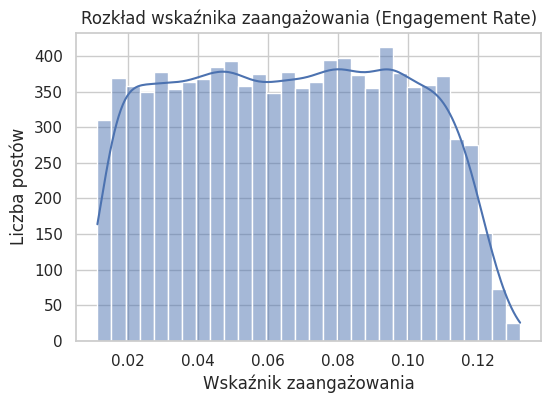

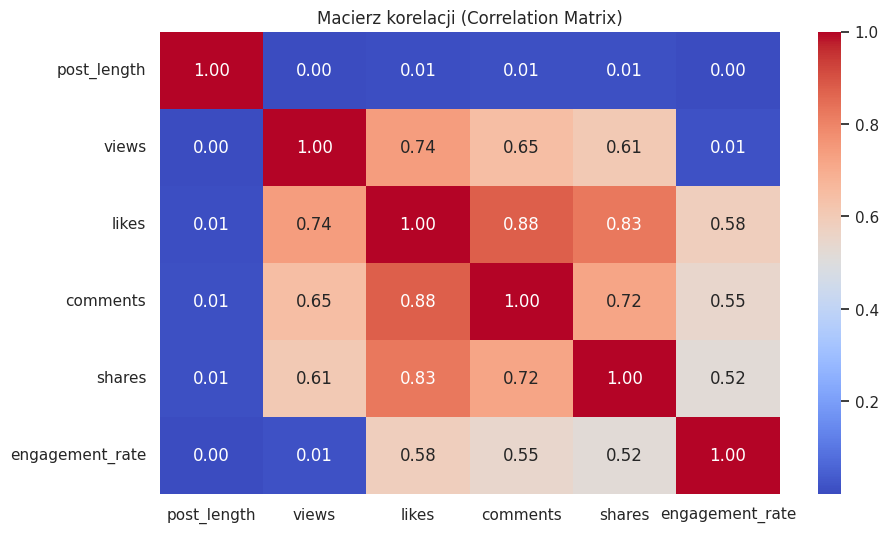

 Próg sukcesu (mediana engagement): 0.06672
 Dane podzielone. Treningowe: 8000, Testowe: 2000

=== Trenowanie modelu bazowego (Logistic Regression) ===
Dokładność (Accuracy): 0.5070

--- Raport klasyfikacji ---
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      1000
           1       0.51      0.53      0.52      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000


=== Trenowanie modelu Random Forest (z optymalizacją) ===
 Najlepsze parametry: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

--- Wyniki najlepszego modelu (Accuracy: 0.5065) ---


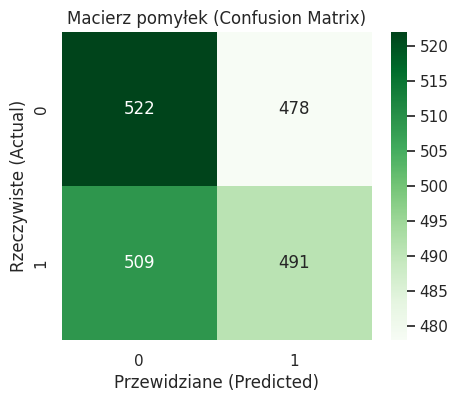

 Model zapisano pomyślnie w pliku: '/content/model_social_media.pkl'


In [ ]:
import os

# Definicja ścieżek
input_csv_path = './content/social_media_engagement_dataset.csv'
output_model_path = './content/model_social_media.pkl'

if not os.path.exists(input_csv_path):
    print(f"Nie znaleziono pliku: '{input_csv_path}'")
    print("Wgraj plik 'social_media_engagement_dataset.csv' do głównego folderu Colab.")
else:
    print(f" Znaleziono plik: {input_csv_path}")

    # Uruchomienie procesu
    handler = DataHandler(input_csv_path)
    df = handler.load_data()

    if df is not None:
        # Analiza
        handler.perform_eda()

        # Przetwarzanie
        processor = DataPreprocessor(df)
        processor.prepare_inputs()

        # Modelowanie
        trainer = ModelTrainer(processor)

        # Porównanie modeli
        trainer.train_baseline()   # Prosty model
        trainer.train_tuned_rf()   # Najlepszy model

        trainer.save_model(output_model_path)

TESTY JEDNOSTKOWE (UNIT TESTS)

In [16]:
print("URUCHAMIANIE TESTÓW JEDNOSTKOWYCH")
print("-"*40)

class TestSocialMediaProject(unittest.TestCase):

    def setUp(self):
        #Tworzenie sztucznych danych do testów (Mock Data)
        self.test_data = pd.DataFrame({
            'platform': ['Facebook', 'Instagram', 'Twitter', 'Facebook'] * 3,
            'post_type': ['Image', 'Video', 'Text', 'Image'] * 3,
            'post_length': [100, 50, 20, 100] * 3,
            'engagement_rate': [0.1, 0.9, 0.05, 0.8, 0.2, 0.95, 0.01, 0.7, 0.15, 0.85, 0.03, 0.6],
            'views': [100] * 12, 'likes': [10] * 12, 'shares': [1] * 12, 'comments': [1] * 12
        })
        self.proc = DataPreprocessor(self.test_data)

    def test_target_creation(self):
        """Test: Czy poprawnie utworzono kolumnę 'is_successful'."""
        self.proc.prepare_inputs()
        self.assertIn('is_successful', self.proc.df.columns)

    def test_data_leakage(self):
        """Test: Czy usunięto kolumny powodujące wyciek danych (np. likes)."""
        X_train, _, _, _ = self.proc.prepare_inputs()
        self.assertNotIn('likes', X_train.columns)
        self.assertNotIn('shares', X_train.columns)

    def test_split_logic(self):
        """Test: Czy poprawnie podzielono dane na zbiory (Train/Test)."""
        X_train, X_test, y_train, y_test = self.proc.prepare_inputs()
        self.assertEqual(len(X_test) + len(X_train), 12)

# Uruchomienie testów
unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.021s

OK


URUCHAMIANIE TESTÓW JEDNOSTKOWYCH
----------------------------------------
 Próg sukcesu (mediana engagement): 0.40000
 Dane podzielone. Treningowe: 9, Testowe: 3
 Próg sukcesu (mediana engagement): 0.40000
 Dane podzielone. Treningowe: 9, Testowe: 3
 Próg sukcesu (mediana engagement): 0.40000
 Dane podzielone. Treningowe: 9, Testowe: 3


Ewaluacja jakości modelu na losowej próbie danych

In [17]:
print("SYMULATOR: Sprawdzanie losowych postów z datasetu")

#  Obliczamy próg sukcesu (Medianę)
threshold = df['engagement_rate'].median()

# 5 losowych wierszy z wczytanego pliku
random_samples = df.sample(n=5)

print(f" Próg sukcesu (Mediana Engagement Rate): {threshold:.5f}")
print("(Jeśli 'Engagement' jest wyższy niż mediana, post jest SUKCESEM)\n")

# Pętla przez wylosowane posty
for index, row in random_samples.iterrows():
    # Pobieranie danych wejściowych
    platform = row['platform']
    p_type = row['post_type']
    length = row['post_length']
    real_engagement = row['engagement_rate']

    # Tworzymy małą tabelkę tylko z cechami (bez engagement_rate!)
    input_data = pd.DataFrame({
        'platform': [platform],
        'post_type': [p_type],
        'post_length': [length]
    })

    # Predykcja
    prediction = trainer.best_model.predict(input_data)[0]
    predicted_label = " SUKCES" if prediction == 1 else " PORAŻKA"

    # Czy w rzeczywistości post był udany
    is_actually_successful = 1 if real_engagement > threshold else 0
    actual_label = " SUKCES" if is_actually_successful == 1 else " PORAŻKA"

    # Porównanie
    match_icon = " ZGADŁ!" if prediction == is_actually_successful else " BŁĄD"

    print(f" Post ID: {index} | {platform} | {p_type} | Długość: {length}")
    print(f" Rzeczywistość: {actual_label} (Eng. Rate: {real_engagement})")
    print(f" Prognoza AI:   {predicted_label}")
    print(f" Wynik testu:   {match_icon}")
    print( "-"*50)

SYMULATOR: Sprawdzanie losowych postów z datasetu
 Próg sukcesu (Mediana Engagement Rate): 0.06672
(Jeśli 'Engagement' jest wyższy niż mediana, post jest SUKCESEM)

 Post ID: 8024 | Twitter | Video | Długość: 85
 Rzeczywistość:  PORAŻKA (Eng. Rate: 0.0464118617028407)
 Prognoza AI:    PORAŻKA
 Wynik testu:    ZGADŁ!
--------------------------------------------------
 Post ID: 680 | Instagram | Image | Długość: 35
 Rzeczywistość:  SUKCES (Eng. Rate: 0.0671770035931885)
 Prognoza AI:    SUKCES
 Wynik testu:    ZGADŁ!
--------------------------------------------------
 Post ID: 5794 | Facebook | Image | Długość: 51
 Rzeczywistość:  SUKCES (Eng. Rate: 0.0780891291982758)
 Prognoza AI:    PORAŻKA
 Wynik testu:    BŁĄD
--------------------------------------------------
 Post ID: 2162 | Twitter | Video | Długość: 96
 Rzeczywistość:  SUKCES (Eng. Rate: 0.1132931760046208)
 Prognoza AI:    SUKCES
 Wynik testu:    ZGADŁ!
--------------------------------------------------
 Post ID: 6925 | Faceboo